In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv('/content/Untitled Folder/credit card.csv',sep=',')

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14595 entries, 0 to 14594
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    14595 non-null  int64  
 1   V1      14595 non-null  float64
 2   V2      14595 non-null  float64
 3   V3      14595 non-null  float64
 4   V4      14595 non-null  float64
 5   V5      14595 non-null  float64
 6   V6      14595 non-null  float64
 7   V7      14595 non-null  float64
 8   V8      14595 non-null  float64
 9   V9      14595 non-null  float64
 10  V10     14595 non-null  float64
 11  V11     14595 non-null  float64
 12  V12     14595 non-null  float64
 13  V13     14595 non-null  float64
 14  V14     14595 non-null  float64
 15  V15     14595 non-null  float64
 16  V16     14595 non-null  float64
 17  V17     14595 non-null  float64
 18  V18     14595 non-null  float64
 19  V19     14595 non-null  float64
 20  V20     14595 non-null  float64
 21  V21     14594 non-null  float64
 22

In [6]:
data.isnull().values.any()

True

Text(0, 0.5, 'Frequency')

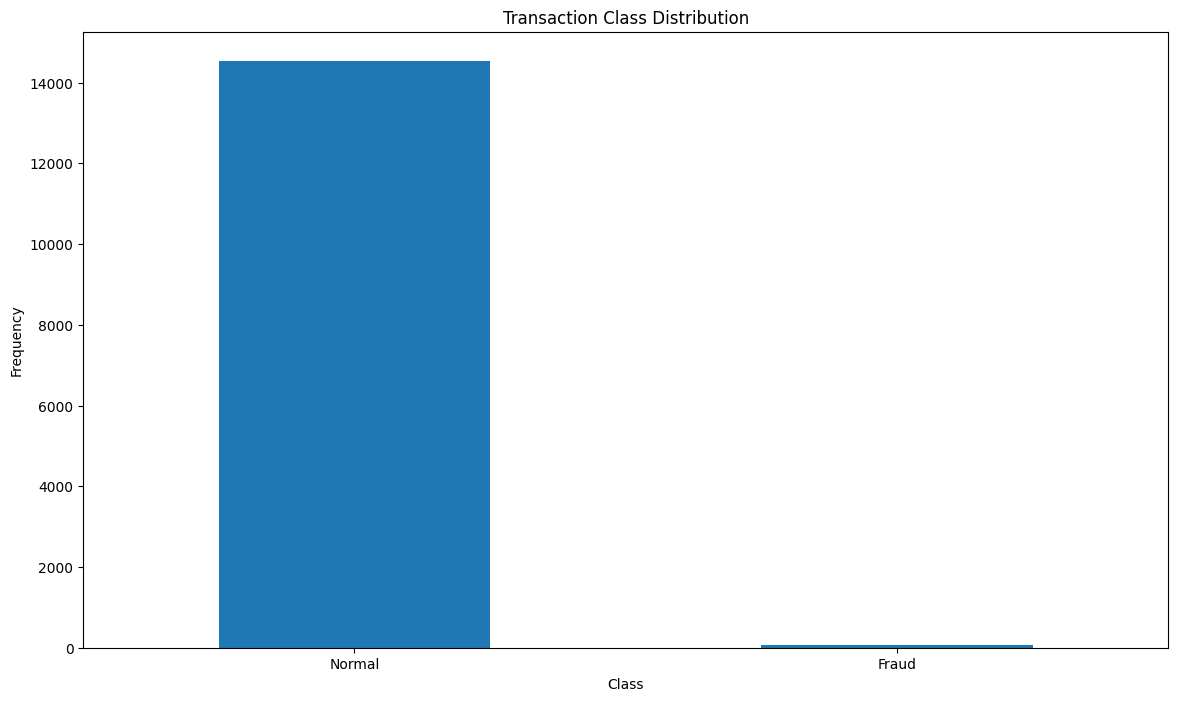

In [7]:
count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [8]:
## Get the Fraud and the normal dataset

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [9]:
print(fraud.shape,normal.shape)

(61, 31) (14533, 31)


In [10]:
fraud.Amount.describe()

count      61.000000
mean       88.402295
std       297.522823
min         0.000000
25%         1.000000
50%         1.000000
75%         3.790000
max      1809.680000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    14533.000000
mean        64.065668
std        176.589083
min          0.000000
25%          5.550000
50%         15.950000
75%         52.990000
max       7712.430000
Name: Amount, dtype: float64

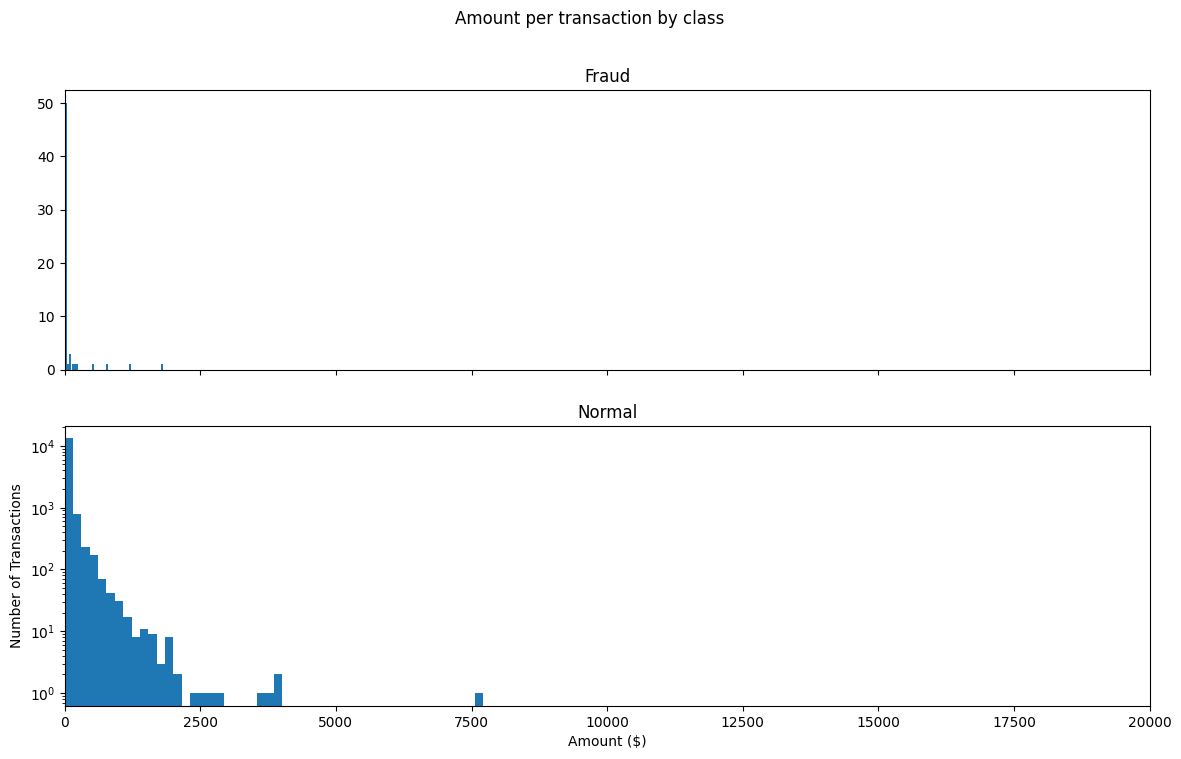

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

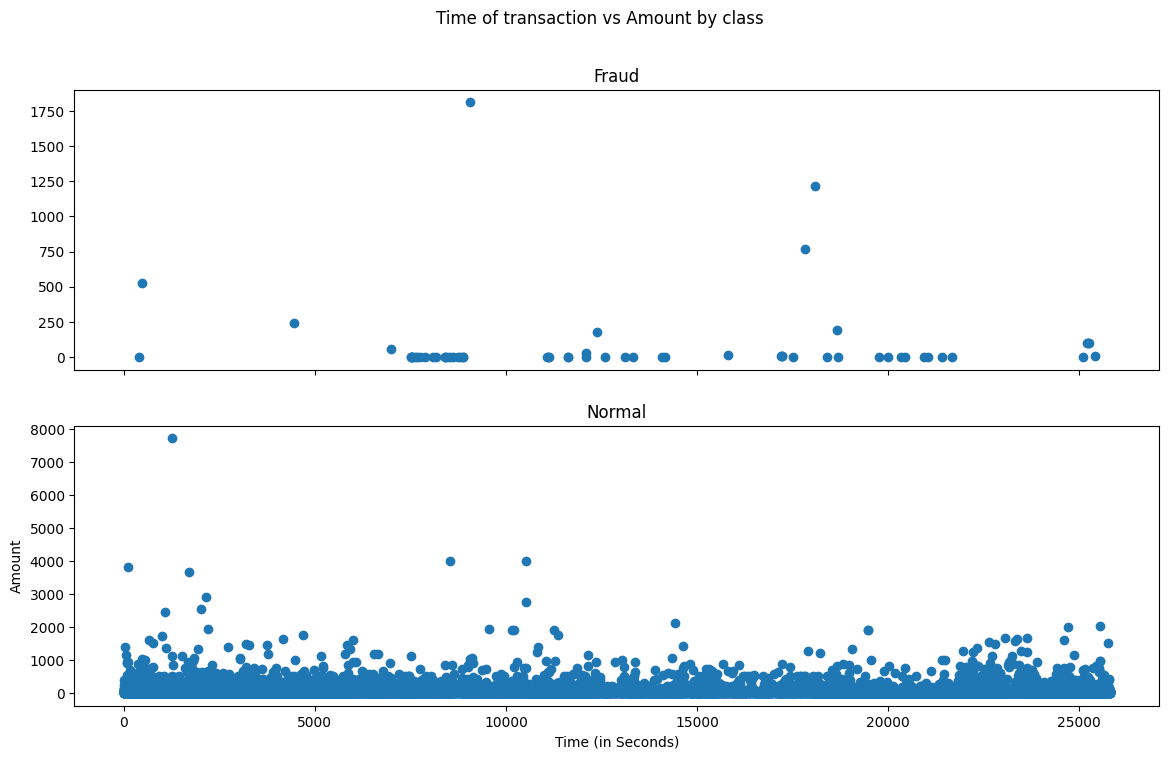

In [13]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [14]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(1460, 31)

In [15]:
data.shape

(14595, 31)

In [16]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [17]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0013717421124828531
Fraud Cases : 2
Valid Cases : 1458


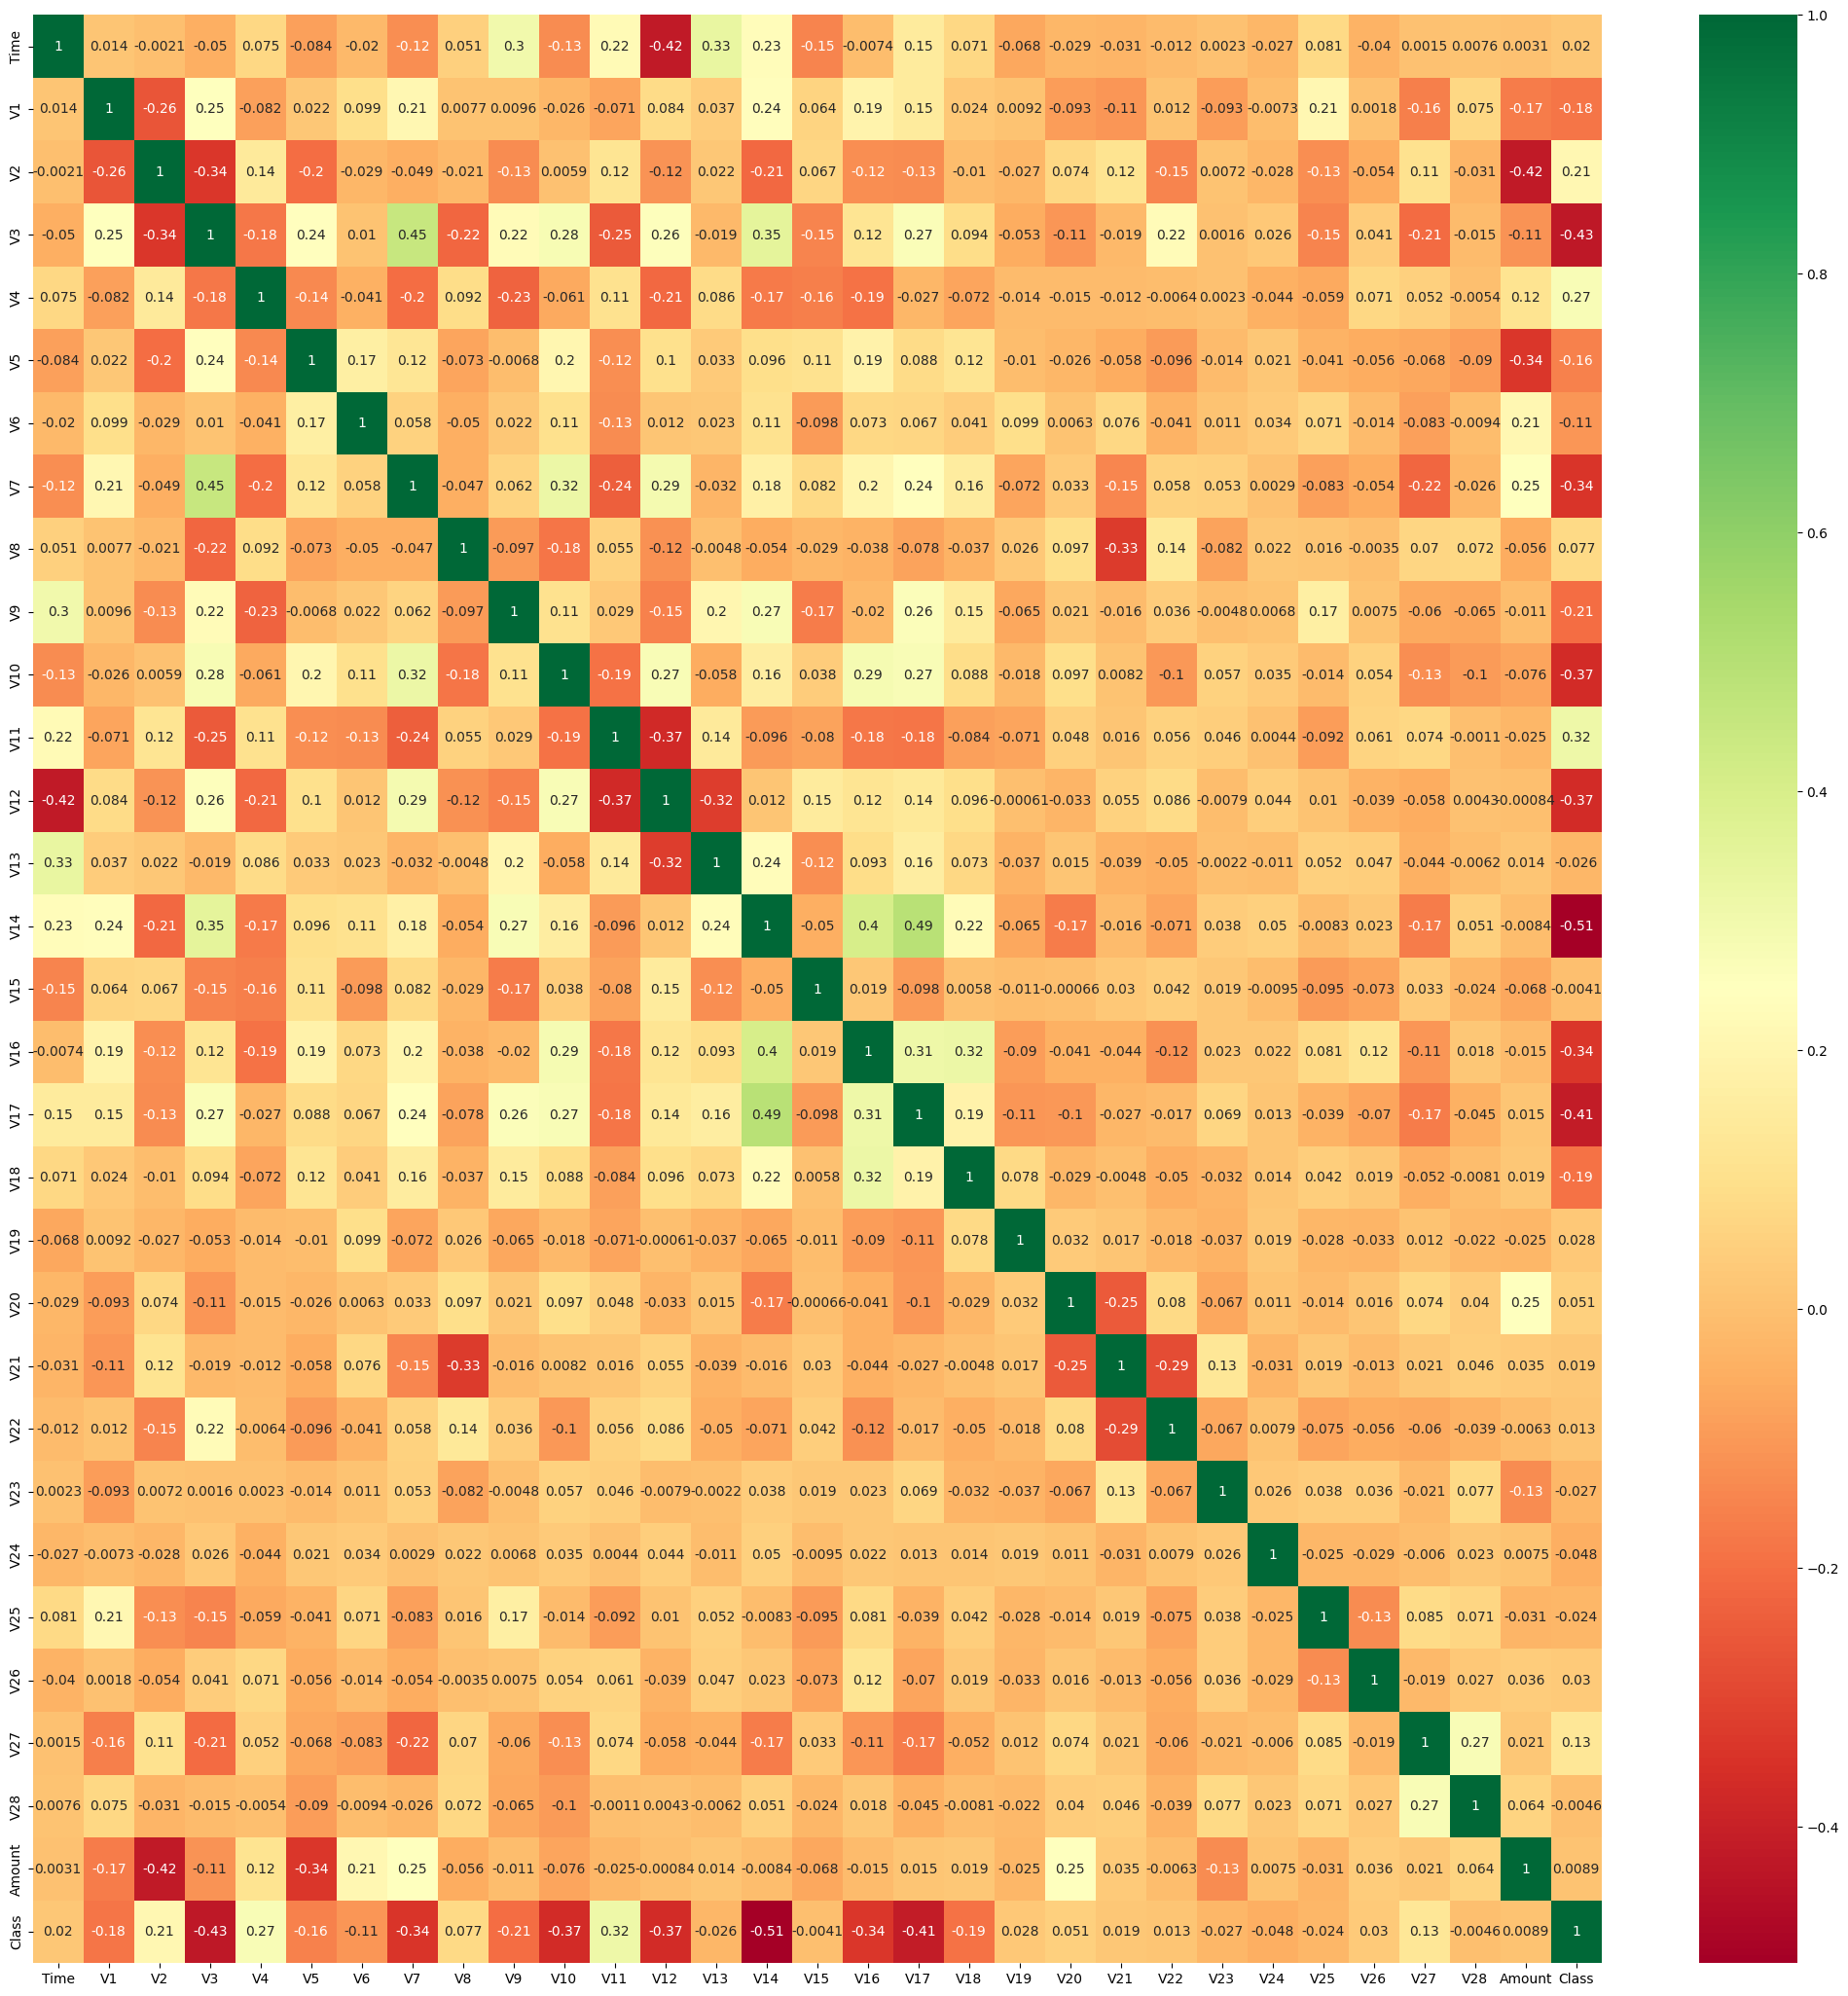

In [18]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(26,26))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [19]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting
target = "Class"
# Define a random state
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(1460, 30)
(1460,)


In [20]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X),
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto',
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,
                                         max_iter=-1)
}

In [21]:
type(classifiers)

dict

In [22]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 3
Accuracy Score :
0.9979452054794521
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1458
         1.0       0.33      0.50      0.40         2

    accuracy                           1.00      1460
   macro avg       0.67      0.75      0.70      1460
weighted avg       1.00      1.00      1.00      1460

Local Outlier Factor: 5
Accuracy Score :
0.9965753424657534
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1458
         1.0       0.00      0.00      0.00         2

    accuracy                           1.00      1460
   macro avg       0.50      0.50      0.50      1460
weighted avg       1.00      1.00      1.00      1460

Support Vector Machine: 603
Accuracy Score :
0.586986301369863
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.59      0